In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import time
from sklearn.metrics import mean_absolute_error 
import seaborn as sns
from ipykernel import kernelapp as app
from sklearn.linear_model import LinearRegression
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
import pywt
import random
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostRegressor

In [18]:
%%time
train_x = pd.read_csv('train_X_features_865.csv')
train_y = pd.read_csv('train_y_features_865.csv')
test_x = pd.read_csv('test_X_features_865.csv')

Wall time: 6 s


In [20]:
X_tr = pd.DataFrame(train_x.drop(0))

y_tr = pd.DataFrame(train_y)

X_test = pd.DataFrame(test_x)

In [23]:
print(y_tr.size)
print(X_tr.size)

17999
15569135


In [24]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [25]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [26]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        

            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=5000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    return oof, prediction

In [28]:
xgb_params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.85, #'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'gamma':0.1}
oof_xgb, prediction_xgb = train_model(params=xgb_params, model_type='xgb')

Fold 0 started at Mon Jun  3 01:15:59 2019
[0]	train-mae:5.16836	valid_data-mae:5.16313
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[500]	train-mae:0.545058	valid_data-mae:1.37173
[1000]	train-mae:0.256389	valid_data-mae:1.2884
[1500]	train-mae:0.126324	valid_data-mae:1.25994
[2000]	train-mae:0.073172	valid_data-mae:1.24831
[2500]	train-mae:0.057478	valid_data-mae:1.24445
[3000]	train-mae:0.052452	valid_data-mae:1.24282
[3500]	train-mae:0.050393	valid_data-mae:1.242
[4000]	train-mae:0.049187	valid_data-mae:1.24152
[4500]	train-mae:0.048425	valid_data-mae:1.24119
[4999]	train-mae:0.047862	valid_data-mae:1.24094
Fold 1 started at Mon Jun  3 02:24:23 2019
[0]	train-mae:5.17396	valid_data-mae:5.14018
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[500]	train-mae:0.518713	valid

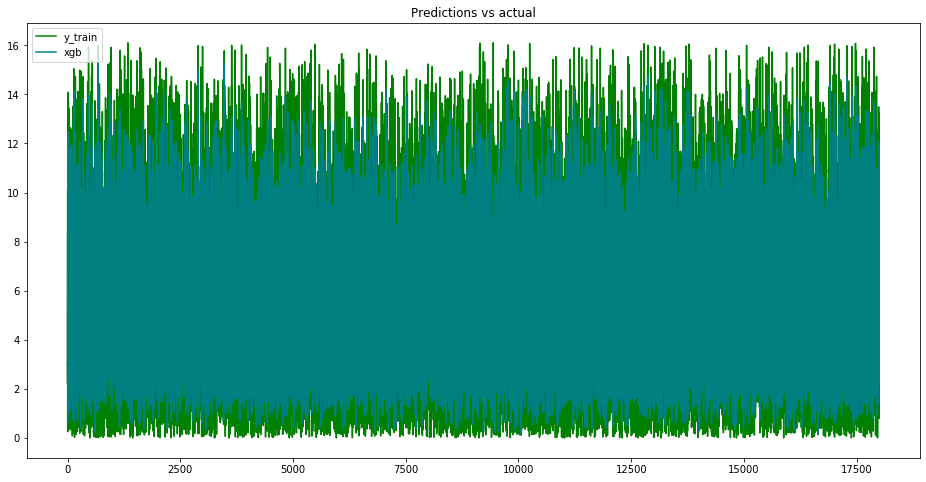

In [30]:
plt.figure(figsize=(16, 8))
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_xgb, color='teal', label='xgb')
plt.legend();
plt.title('Predictions vs actual');

In [32]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_xgb
print(submission.head())
submission.to_csv('submission_xgb.csv')

            time_to_failure
seg_id                     
seg_00030f         3.484015
seg_0012b5         5.007507
seg_00184e         5.807801
seg_003339         9.018702
seg_0042cc         6.372834
